In [46]:
from bs4 import BeautifulSoup
import pandas
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.colors
import networkx as nx
from numpy.linalg import eigh

In [2]:
opinions = pandas.read_csv("opinions_sample.csv", sep=";")
list(opinions)

['absolute_url',
 'author',
 'author_str',
 'cluster',
 'date_created',
 'date_modified',
 'download_url',
 'extracted_by_ocr',
 'html',
 'html_lawbox',
 'html_with_citations',
 'joined_by',
 'local_path',
 'opinions_cited',
 'per_curiam',
 'plain_text',
 'resource_uri']

In [4]:
columns = ['case_cite','parties','docket','court','date','intent']
extracted_data = pandas.DataFrame(columns=columns)

In [20]:
extraction = opinions.absolute_url.str.split('/',expand = True)
extracted_id = extraction[extraction.columns[2]]

In [5]:
missing_html=[]
for i in range(len(opinions.html)):
    case_cite, parties, docket, court, date, indent = (list(),)*6
    try:
        soup = BeautifulSoup(opinions.html[i],"html.parser")
        try:
            case_cite = soup.findAll("p", {"class": "case_cite"})
        except:
            print("No Case Cite")
        try:
            parties = soup.findAll("p", {"class": "parties"})
        except:
            print("No parties")
        try:
            docket = soup.findAll("p", {"class": "docket"})
        except:
            print("No docket")
        try:
            court = soup.findAll("p", {"class": "court"})
        except:
            print("No court")
        try:
            date = soup.findAll("p", {"class": "date"})
        except:
            print("No date")
        try:
            indent = soup.findAll("p", {"class": "indent"})
        except:
            print("No indent")
        extracted_data.loc[i] = [[obs.get_text() for obs in case_cite],[obs.get_text() for obs in parties],[obs.get_text() for obs in docket],[obs.get_text() for obs in court],[obs.get_text() for obs in date],[obs.get_text() for obs in indent]]
    except:
        missing_html.append(i)

In [23]:
extracted_data = extracted_data.assign(id = extracted_id)
extracted_data.head()
extracted_data.case_cite = [[id.split()[0] for id in case] for case in extracted_data.case_cite]

In [31]:
int_list = []
for index, element in extracted_data.iterrows():
    try :
        int_list.append(list(map(int, element.case_cite)))
    except:
        int_list.append([])
extracted_data.case_cite = int_list
case_relation = pandas.concat([extracted_data.id, extracted_data.case_cite], axis = 1)

In [34]:
case_relation.head()

,id,case_cite
0,143119,[544]
1,122028,[536]
2,92451,"[130, 9, 32]"
3,134300,[540]
5,89793,"[97, 24]"


In [39]:
case_cite_graph = nx.DiGraph()

for index, element in case_relation.iterrows():
    case_cite_graph.add_node(element.id, attr_dict={"is_case": True})
    for link in element.case_cite:
        case_cite_graph.add_node(link, attr_dict={"is_case": False})
        case_cite_graph.add_edge(element.id, link)

(-0.10500000000000001, 1.105, -0.10451587468385698, 1.0999051573872567)

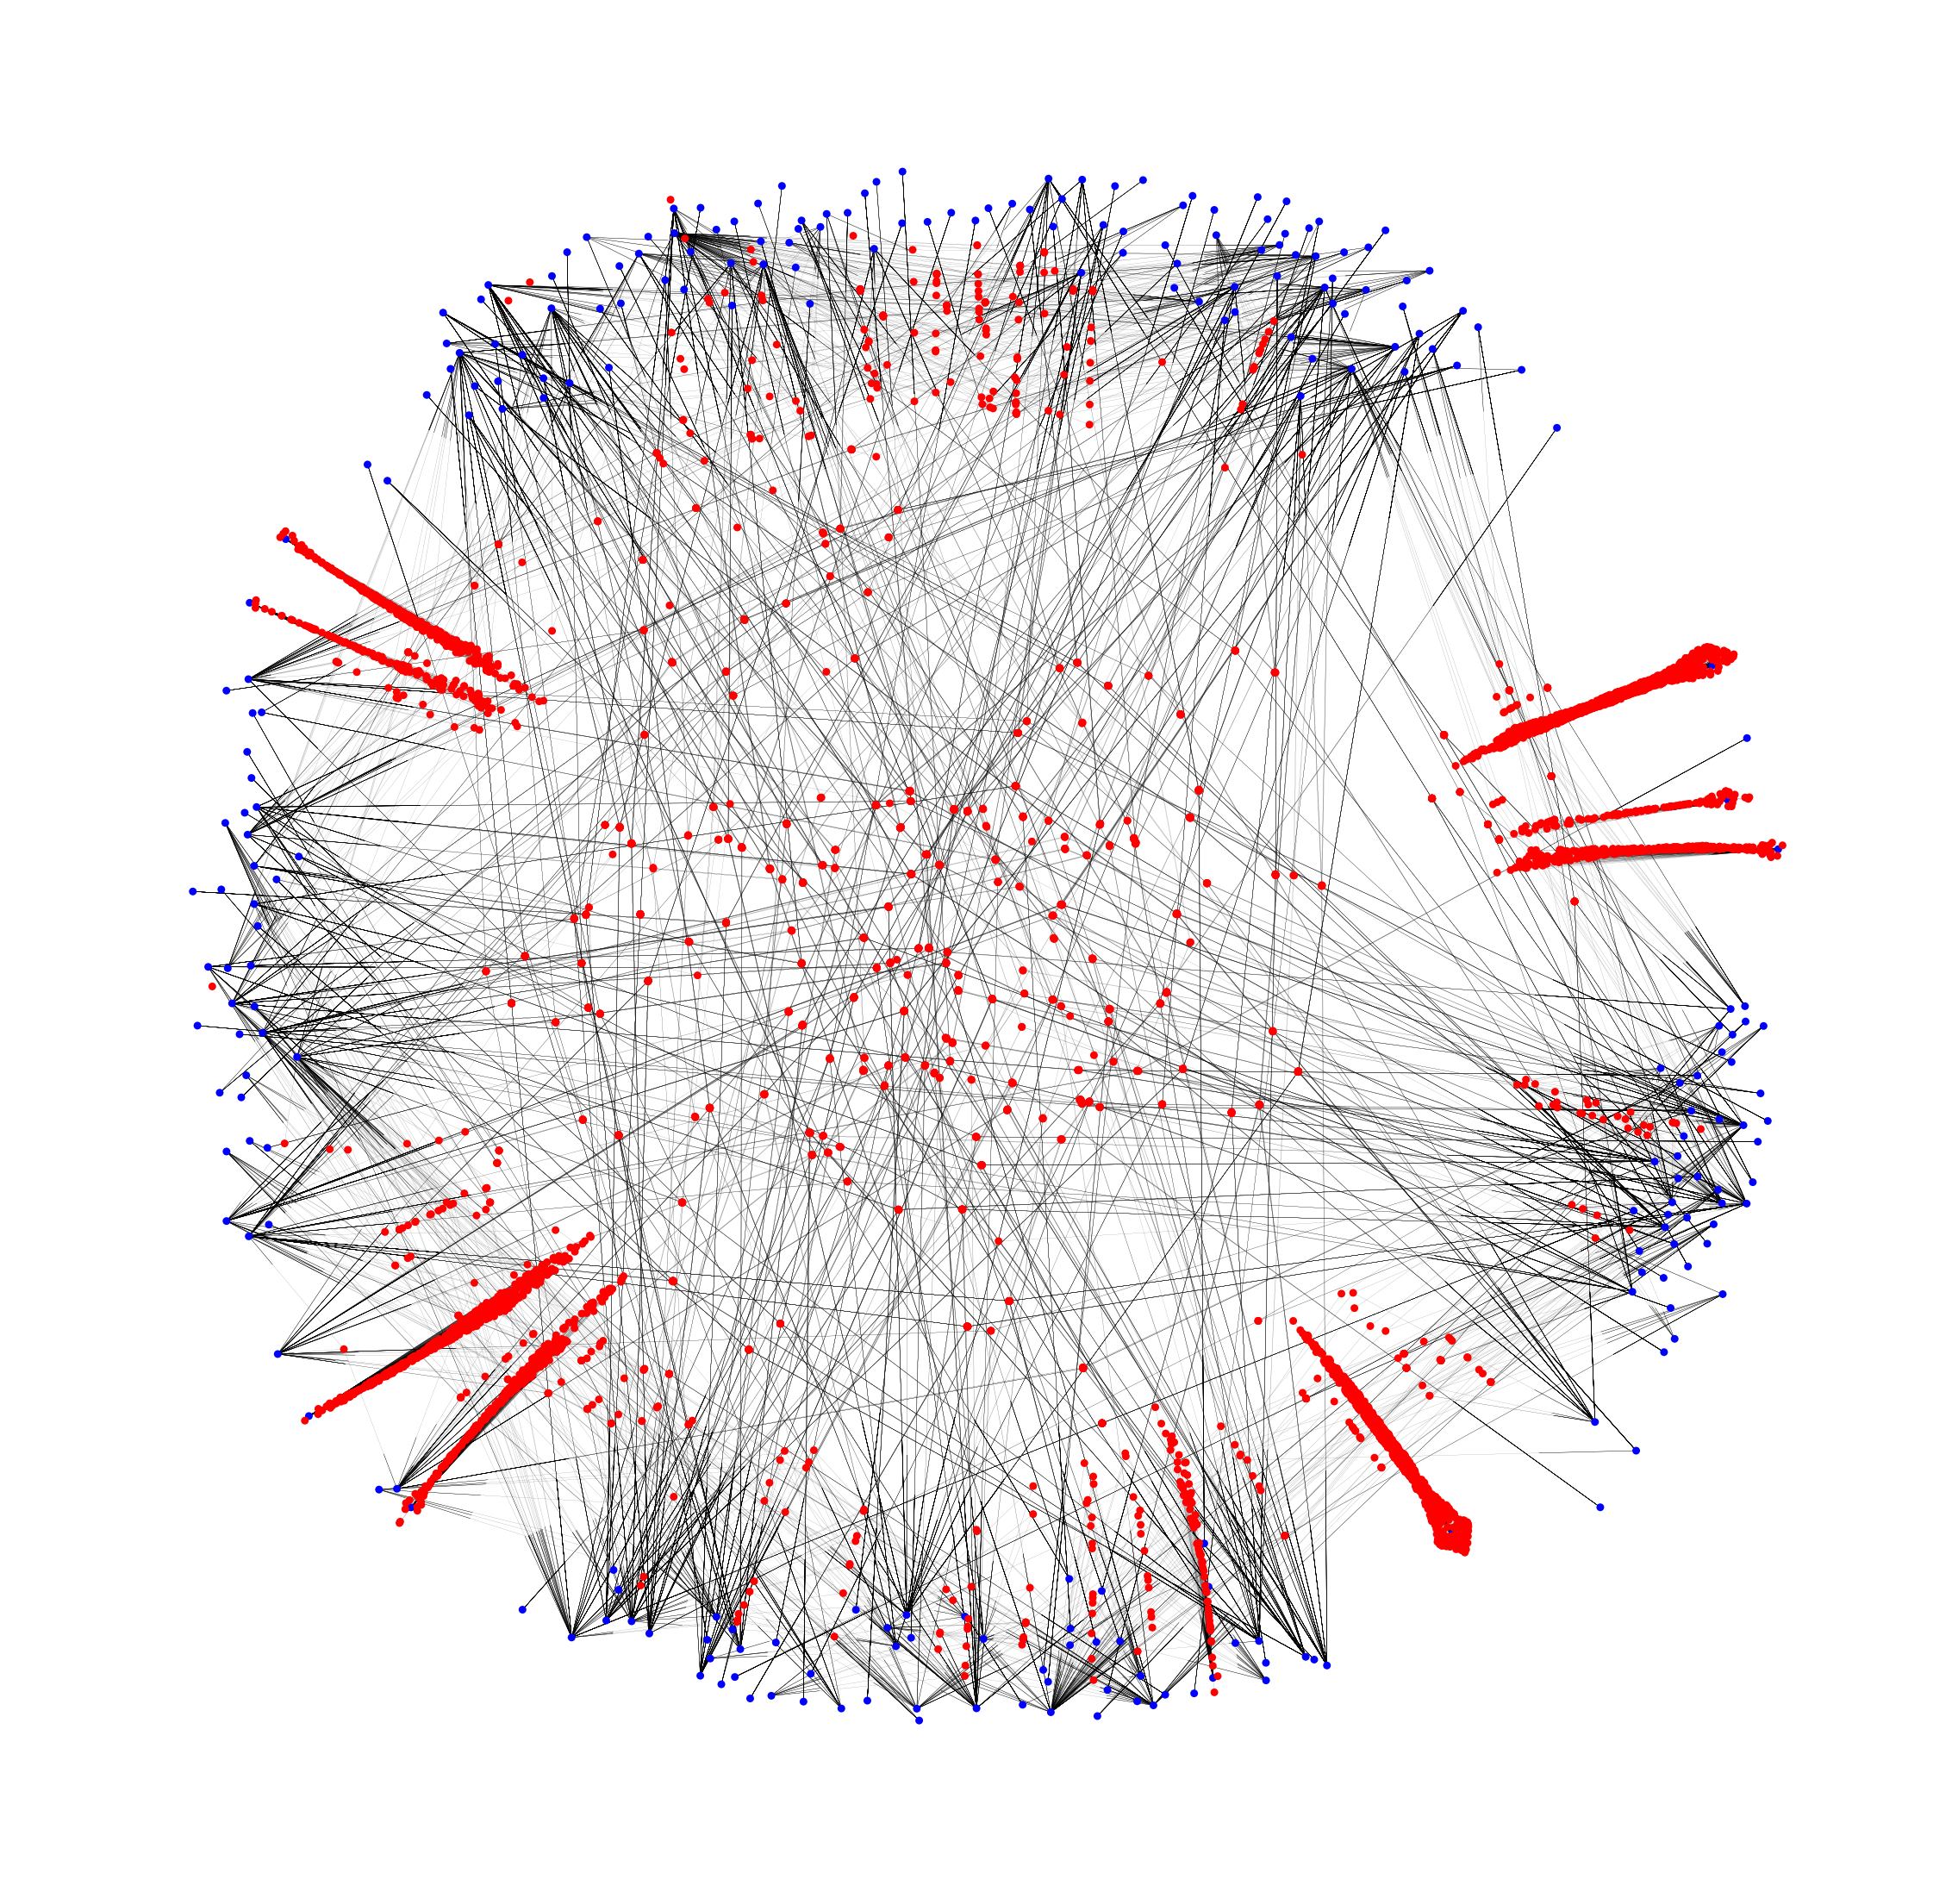

In [42]:
%matplotlib inline
plt.figure(figsize=(40,40))
colors = ['r' if case_cite_graph.node[n]['is_case'] else 'b' for n in case_cite_graph]
nx.draw_networkx(case_cite_graph, node_size=80, pos = nx.spring_layout(case_cite_graph), node_color=colors, linewidths=0, width=0.1, with_labels = False)
plt.axis('off')

In [44]:
laplacian = nx.directed_laplacian_matrix(case_cite_graph)

In [47]:
eig_vals, eig_vectors = eigh(laplacian.A)

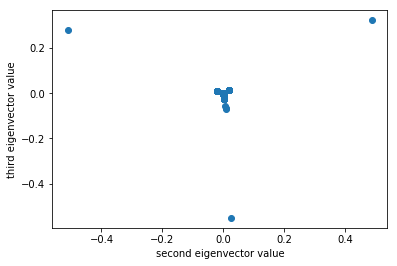

In [48]:
plt.figure()
plt.plot(eig_vectors[:,1], eig_vectors[:,2],'o')
plt.xlabel('second eigenvector value')
plt.ylabel('third eigenvector value')
plt.show()